In [62]:
import torch
import torch.nn as nn
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np

In [63]:
class LSTM(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size = 1, hidden_size = self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self,x):
        x,_ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)
        return x

num_hidden = 100 #モデルのLSTMブロックの数を定義
lr = 0.001 #ラーニングレートを設定
num_epoch = 100   
model = LSTM(num_hidden)
optimizer = optim.SGD(model.parameters(),lr = lr)

In [64]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [65]:
class make_datasets:#データの前処理を行えるクラス
    def __init__(self,csv_file,col_name, type, num_window=0):
        raw_data = pd.read_csv(csv_file)
        self.price = raw_data[col_name]
        self.date = raw_data["date"]
        self.seq_arr = []
        self.target_arr = []
        self.seq_train = []
        self.target_train = []
        self.seq_test = []
        self.target_test = []
        if type == "lstm":
            self.make_data_for_lstm(num_window)
        elif type == "mlp":
            self.make_data_for_mlp()
        else:
            print("type:{}は存在しません".format(type))
        
    def make_data_for_lstm(self, num_window): #LSTMのためのデータセットを作成する
        num_data = len(self.price)
        seq_data = []
        target_data = []
        for i in range(num_data - num_window):
            seq_data.append(self.price[i:i+num_window])
            target_data.append(self.price[i+num_window:1+i+num_window])
        self.seq_arr = np.array(seq_data)
        self.target_arr = np.array(target_data)
    
    def make_data_for_mlp(self):
        pass#今後実装
    
    def lstm_train_data(self,num_test):
        self.seq_train = FloatTensor(self.seq_arr[:-num_test].astype(np.float32))
        self.target_train = FloatTensor(self.target_arr[:-num_test].astype(np.float32))
        self.seq_test = FloatTensor(self.seq_arr[-num_test :].astype(np.float32))
        self.target_test = FloatTensor(self.target_arr[-num_test :].astype(np.float32))
        return self.seq_train, self.target_train, self.seq_test, self.target_test

In [66]:
dataset = make_datasets("~/Projects/raw_data/1925.csv",type="lstm",col_name = "opening_price",num_window = 30)

In [67]:
dataset.seq_arr
print(dataset.target_arr)

[[3092.]
 [3087.]
 [3000.]
 ...
 [3330.]
 [3281.]
 [3270.]]


In [68]:
seq_train_t, target_train_t, seq_test_t, target_test_t = dataset.lstm_train_data(30)
print(type(seq_train_t), type(target_train_t))



<class 'torch.Tensor'> <class 'torch.Tensor'>


In [69]:
seq_train_t = seq_train_t.permute(1,0) #次元の入れ替え
target_train_t= target_train_t.permute(1,0) 
seq_train_t = seq_train_t.unsqueeze(dim = -1) #３次元にする
target_train_t = target_train_t.unsqueeze(dim = -1)
criterion = nn.MSELoss()
num_hidden = 30 #モデルのLSTMブロックの数を定義
lr = 0.5 #ラーニングレートを設定
num_epoch = 1000
model = LSTM(num_hidden)
optimizer = optim.Adam(model.parameters(),lr = lr)


In [70]:
def learn(x,y,num_epoch):
    losses = []
    for epoch in range(num_epoch):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if epoch % 1000 == 0:
            print("epoch{} : loss{}".format(epoch,loss.item()))
        plt.plot(losses)

epoch0 : loss11411633.0
/home/ikrfun/anaconda3/envs/torch_env/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1248, 1])) that is different to the input size (torch.Size([1248, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


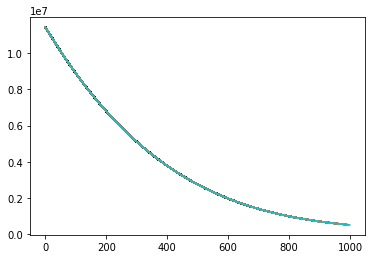

In [71]:

x = seq_train_t.to(device)
y = target_train_t.to(device)
model.to(device)
learn(x,y,num_epoch)

In [72]:
def run_test(data):
    model.eval()
    data= data.permute(1,0)
    data = data.unsqueeze(dim = -1)
    data = data.to(device)
    y_pred = model(data)
    y_pred = y_pred.to("cpu")
    y_pred = y_pred.detach().numpy()
    plt.plot(y_pred)


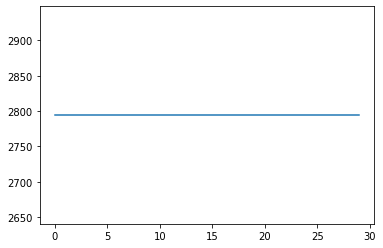

In [73]:
run_test(seq_test_t)

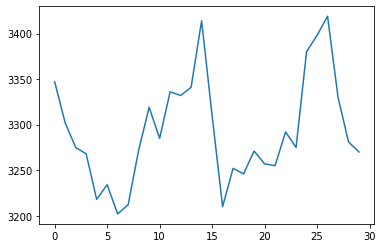

In [75]:
plt.plot(target_test_t.detach().numpy())